<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/LanguageAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install fairseq sacrebleu sentencepiece


     |████████████████████████████████| 307kB 39.8MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 1.0MB 55.3MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2035361 sha256=48e195a317ddeabf7d24f39a3e3ffc63fcdf7ac10f81c5d2e3f2d63ec2a83431
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq


In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=8c0cfc6deba8449c46eca8cb38d97bee2120c98473d758d901511f70dad32918
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 159.7 MB
GPU RAM Free: 7611MB | Used: 0MB | Util   0% | Total 7611MB


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls
%cd drive/My Drive/ConfidentMachineTranslation/flores
!ls
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data
/content/drive/My Drive/ConfidentMachineTranslation/flores
analysis	 data	       LanguageAnalysis.ipynb  NoisyChannel.ipynb
Analysis	 data-bin      language_models	       Resources
backward_models  Ensembles     LM_Thresholding.ipynb   scripts
checkpoints	 Ensembling    NCD_Analysis.ipynb
configs		 FLORES.ipynb  noisychannel
/content/drive/My Drive/ConfidentMachineTranslation/flores


In [0]:
!fairseq-generate \
    data-bin/wiki_ne_en_bpe5000/ \
    --source-lang ne --target-lang en \
    --path Ensembles/April_04.pt \
    --beam 5 --lenpen 1.2 \
    --gen-subset train \
    --remove-bpe=sentencepiece \
    --sacrebleu > analysis/testSet_BLEU.txt

  0% 0/802 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [0]:
from statistics import mean, median 

bleu_res = open("analysis/testSet_BLEU.txt", "r")
NMT_original = open("analysis/original_sentences.txt", "w")
NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "w")
NMT_output = open("analysis/translated_sentences.txt", "w")
Sentence_stats = open("analysis/logprob_statistics.txt", "w")

for line in bleu_res:

    if line.startswith("H-"):
        NMT_output.write(line.split("	")[2])
    elif line.startswith("T-"):
        NMT_ground_truth.write(line.split("	")[1])
    elif line.startswith("S-"):
        NMT_original.write(line.split("	")[1])
    elif line.startswith("P-"):
        scores = [float(i) for i in line.split("\t")[1].split(" ")]
        Sentence_stats.write(str(mean(scores))+" "+str(min(scores))+" "+str(median(scores))+" "+str(max(scores))+"\n")

NMT_ground_truth.close()
NMT_output.close()
Sentence_stats.close()
NMT_original.close()



In [0]:
!fairseq-score --sys analysis/translated_sentences.txt --ref analysis/ground_truth_sentences.txt --sentence-bleu > analysis/scores.txt

In [0]:
from itertools import zip_longest
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from numpy import arange
import subprocess
import random
import numpy as np


class Translation:
    def __init__ (self, ref, out, orig, score):
        self.reference = ref
        self.translation = out
        self.original = orig
        self.score = score
    def __repr__(self):
        return str(self.score)

def compute_excluded_included_score (translations, split_index):
    temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
    temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

    temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
    temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")

    for i in range(len(translations)):
        if i < split_index:
            temporary_reference_exclusion.write(translations[i].reference)
            temporary_output_exclusion.write(translations[i].translation)
        else:
            temporary_reference_inclusion.write(translations[i].reference)
            temporary_output_inclusion.write(translations[i].translation)

    temporary_reference_inclusion.close()
    temporary_output_inclusion.close()
    temporary_reference_exclusion.close()
    temporary_output_exclusion.close()

    !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt
    !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

    temporary_inclusion_result = open("analysis/inclusion_result.txt")
    temporary_exclusion_result = open("analysis/exclusion_result.txt")
    inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]
    exclusion_result_string = [line for line in temporary_exclusion_result][1].split(" ")[2]

    return float(exclusion_result_string), float(inclusion_result_string)


NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "r")
NMT_output = open("analysis/translated_sentences.txt", "r")
NMT_original = open("analysis/original_sentences.txt", "r")
Sentence_stats = open("analysis/logprob_statistics.txt", "r")
Sentence_bleu = open("analysis/scores.txt", "r")

next(Sentence_bleu)
files = [NMT_ground_truth, NMT_output, NMT_original, Sentence_stats, Sentence_bleu]
translations = []

for lines in zip_longest(*files, fillvalue=''):
    reference, translation, original, stats, sentence_bleu = lines
    sentence_bleu = float(sentence_bleu.split("BLEU4 = ")[1].split(",")[0])
    stats = [float(i) for i in stats.strip("\n").split(" ")]
    stats.append(sentence_bleu)
    stats.extend([0,0,0])
    translations.append(Translation(reference, translation, original, stats))

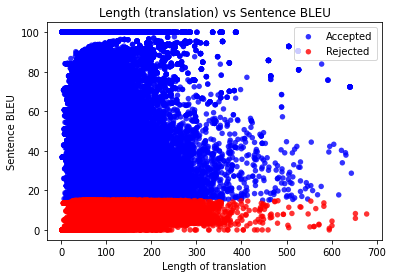

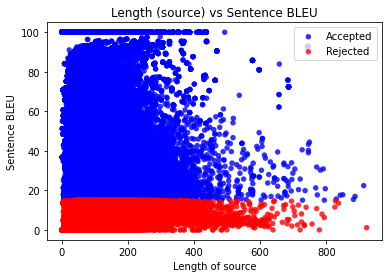

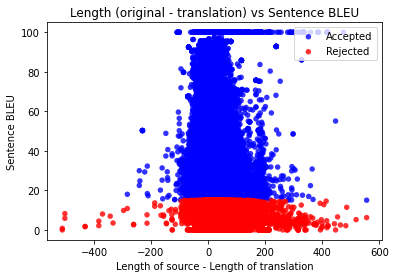

In [0]:
# for translation in translations:
#     print("Original = " + translation.original)
#     print("GT = " + translation.reference)
#     print("Translation = " + translation.translation)
#     print("Score = " + str(translation.score))


accepted_set_english = [[],[]]
rejected_set_english = [[],[]]

accepted_set_nepali = [[],[]]
rejected_set_nepali = [[],[]]

accepted_set_difference = [[],[]]
rejected_set_difference = [[],[]]

for translation in translations:
    if translation.score[4] > 15:
        accepted_set_english[0].append(len(translation.translation))
        accepted_set_english[1].append(translation.score[4])

        accepted_set_nepali[0].append(len(translation.original))
        accepted_set_nepali[1].append(translation.score[4])

        accepted_set_difference[0].append(len(translation.original) - len(translation.translation))
        accepted_set_difference[1].append(translation.score[4])

    else:
        rejected_set_english[0].append(len(translation.translation))
        rejected_set_english[1].append(translation.score[4])

        rejected_set_nepali[0].append(len(translation.original))
        rejected_set_nepali[1].append(translation.score[4])

        rejected_set_difference[0].append(len(translation.original) - len(translation.translation))
        rejected_set_difference[1].append(translation.score[4])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(accepted_set_english[0], accepted_set_english[1], alpha=0.8, c="blue", edgecolors='none', s=30, label="Accepted")
ax.scatter(rejected_set_english[0], rejected_set_english[1], alpha=0.8, c="red", edgecolors='none', s=30, label="Rejected")


plt.xlabel('Length of translation') 
plt.ylabel('Sentence BLEU') 
plt.title('Length (translation) vs Sentence BLEU')
plt.legend(loc=1)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(accepted_set_nepali[0], accepted_set_nepali[1], alpha=0.8, c="blue", edgecolors='none', s=30, label="Accepted")
ax.scatter(rejected_set_nepali[0], rejected_set_nepali[1], alpha=0.8, c="red", edgecolors='none', s=30, label="Rejected")
plt.xlabel('Length of source') 
plt.ylabel('Sentence BLEU')
plt.title('Length (source) vs Sentence BLEU')
plt.legend(loc=1)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(accepted_set_difference[0], accepted_set_difference[1], alpha=0.8, c="blue", edgecolors='none', s=30, label="Accepted")
ax.scatter(rejected_set_difference[0], rejected_set_difference[1], alpha=0.8, c="red", edgecolors='none', s=30, label="Rejected")
plt.xlabel('Length of source - Length of translation') 
plt.ylabel('Sentence BLEU')
plt.title('Length (original - translation) vs Sentence BLEU')
plt.legend(loc=1)
plt.show()


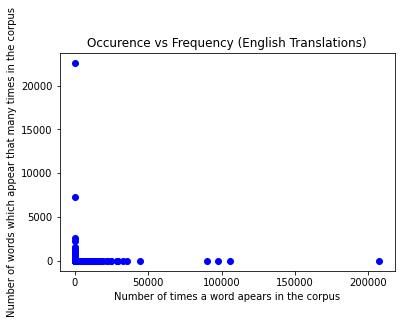

In [0]:
import string

dict_english = {}

for translation in translations:
    english_translation = translation.translation.split()
    for word in english_translation:
        if len(word) > 1:
            word = word.translate(str.maketrans({a:None for a in string.punctuation}))

            if word in dict_english:
                dict_english[word] = 1 + dict_english[word]
            else: 
                dict_english[word] = 1

# for word in dict_english:
#     if dict_english[word] == 1:
#         print(word)

dict_occ_to_freq = {}

for word in dict_english:
    if dict_english[word] in dict_occ_to_freq:
        dict_occ_to_freq[dict_english[word]] = 1 + dict_occ_to_freq[dict_english[word]]
    else: 
        dict_occ_to_freq[dict_english[word]] = 1


x = []
y = []

for occ in dict_occ_to_freq:
    x.append(occ)
    y.append(dict_occ_to_freq[occ])

# print(dict_occ_to_freq[1])

plt.xlabel('Number of times a word apears in the corpus') 
plt.ylabel('Number of words which appear that many times in the corpus') 
plt.title('Occurence vs Frequency (English Translations)')
plt.scatter(x, y, color= "blue") 
plt.show()  


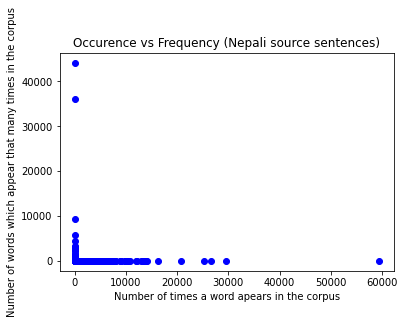

In [0]:
import string

dict_nepali = {}

for translation in translations:
    nepali_transaltions = translation.original.split()
    for word in nepali_transaltions:
        if len(word) > 1:
            word = word.translate(str.maketrans({a:None for a in string.punctuation}))

            if word in dict_nepali:
                dict_nepali[word] = 1 + dict_nepali[word]
            else: 
                dict_nepali[word] = 1

# for word in dict_nepali:
#     if dict_nepali[word] == 1:
#         print(word)

dict_occ_to_freq = {}

for word in dict_nepali:
    if dict_nepali[word] in dict_occ_to_freq:
        dict_occ_to_freq[dict_nepali[word]] = 1 + dict_occ_to_freq[dict_nepali[word]]
    else: 
        dict_occ_to_freq[dict_nepali[word]] = 1


x = []
y = []

for occ in dict_occ_to_freq:
    x.append(occ)
    y.append(dict_occ_to_freq[occ])

# print(dict_occ_to_freq[1])

plt.xlabel('Number of times a word apears in the corpus') 
plt.ylabel('Number of words which appear that many times in the corpus') 
plt.title('Occurence vs Frequency (Nepali source sentences)')
plt.scatter(x, y, color= "blue") 
plt.show()  

In [0]:
rare_threshold = 2
for translation in translations:
    translation_source = translation.original.split()
    translation_trans = translation.translation.split()

    rare_source_num = 0
    for word in translation_source:
        if len(word) > 1:
            word = word.translate(str.maketrans({a:None for a in string.punctuation}))
            if dict_nepali[word] <= rare_threshold:
                rare_source_num += 1

    rare_translation_num = 0
    for word in translation_trans:
        if len(word) > 1:
            word = word.translate(str.maketrans({a:None for a in string.punctuation}))
            if dict_english[word] <= rare_threshold:
                rare_translation_num += 1

    # if rare_source_num < 0 or rare_translation_num < 0:
    #     print(str([rare_source_num, rare_translation_num]))
    # print(str([rare_source_num, rare_translation_num, rare_source_num - rare_translation_num]))
    translation.score[5:] = [rare_source_num, rare_translation_num, rare_source_num - rare_translation_num]

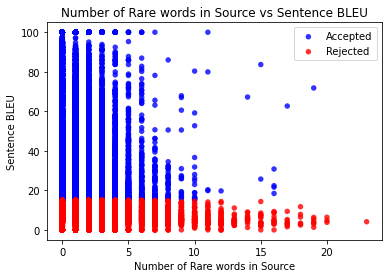

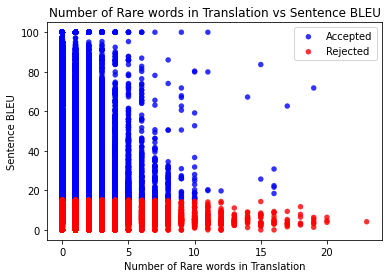

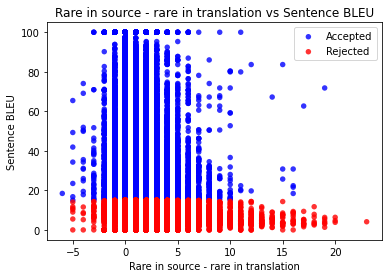

In [0]:
accepted_set_stats = [[],[]]
rejected_set_stats = [[],[]]

index_to_label = {0: "Average Logprob", 1: "Min Logprob", 2: "Median Logprob", 3: "Max Logprob", 5: "Number of Rare words in Source", 6: "Number of Rare words in Translation", 7: "Rare in source - rare in translation"}
indices = [5,6,7]

for i in indices:
    for translation in translations:  
        if translation.score[4] > 15:
            accepted_set_stats[0].append(translation.score[i])
            accepted_set_stats[1].append(translation.score[4])
        else:
            rejected_set_stats[0].append(translation.score[i])
            rejected_set_stats[1].append(translation.score[4])

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(accepted_set_stats[0], accepted_set_stats[1], alpha=0.8, c="blue", edgecolors='none', s=30, label="Accepted")
    ax.scatter(rejected_set_stats[0], rejected_set_stats[1], alpha=0.8, c="red", edgecolors='none', s=30, label="Rejected")

    plt.xlabel(index_to_label[i]) 
    plt.ylabel('Sentence BLEU') 
    plt.title(index_to_label[i] + ' vs Sentence BLEU')
    plt.legend(loc=1)
    plt.show()

In [0]:
rejected_sentences = open("analysis/rejected_sentences_in_train.txt", "w")
accepted_sentences = open("analysis/accepted_sentences_in_train.txt", "w")

for translation in translations:  
        if translation.score[4] > 15:
            accepted_sentences.write("Original = " + translation.original)
            accepted_sentences.write("Reference = " + translation.reference)
            accepted_sentences.write("Translation = " + translation.translation)
            accepted_sentences.write("Sentence BLEU = " + str(translation.score[4]) + " \n")
        else:
            rejected_sentences.write("Original = " + translation.original)
            rejected_sentences.write("Reference = " + translation.reference)
            rejected_sentences.write("Translation = " + translation.translation)
            rejected_sentences.write("Sentence BLEU = " + str(translation.score[4]) + "\n")


rejected_sentences.close()
accepted_sentences.close()
            

In [0]:
%cd noisychannel
beam=5
fw_name="ne-en"
bw_name="en-ne"
data_dir="../data-bin/wiki_ne_en_bpe5000"
data_dir_name="ncd_without_ensembling"
lm="../language_models/lm/checkpoint_best.pt"
lm_bpe_code="../language_models/lm/bpe32k.code"
lm_dict="../language_models/lm/dict.txt"
batch_size=32
bw="../backward_models/April_17.pt"
fw="../Ensembles/April_04.pt"
source_lang = "ne"
target_lang = "en"

!python rerank.py $data_dir \
    --lenpen 1.2 --weight1 1 --weight2 0 --weight3 0  --gen-subset train\
    --data-dir-name $data_dir_name  --source-lang $source_lang --target-lang $target_lang --gen-model $fw \
    -n $beam --batch-size $batch_size --score-model2 $fw --score-model1 $bw --backwards1  \
    -lm $lm  --lm-dict $lm_dict  --lm-name en_newscrawl --lm-bpe-code $lm_bpe_code \
    --model2-name $fw_name --model1-name $bw_name --gen-model-name $fw_name --sacrebleu

%cd ..
!pwd

/content/drive/My Drive/ConfidentMachineTranslation/flores/noisychannel
tcmalloc: large alloc 1348632576 bytes == 0x5416e000 @  0x7f0b9d93b1e7 0x54485f 0x52dc9d 0x52ed2f 0x53e34a 0x4f27d0 0x50a2bf 0x50bfb4 0x507d64 0x5090b7 0x594931 0x5a47fc 0x5a5cda 0x4baf4c 0x5bcf53 0x50a2bf 0x50bfb4 0x509758 0x50a48d 0x50bfb4 0x507d64 0x509042 0x594931 0x549e5f 0x5513d1 0x5a9cbc 0x50a5c3 0x50cd96 0x509758 0x50a48d 0x50bfb4
tcmalloc: large alloc 2697256960 bytes == 0xa4796000 @  0x7f0b9d93b1e7 0x54485f 0x52dc9d 0x52ed2f 0x53e34a 0x4f27d0 0x50a2bf 0x50bfb4 0x507d64 0x5090b7 0x594931 0x5a47fc 0x5a5cda 0x4baf4c 0x5bcf53 0x50a2bf 0x50bfb4 0x509758 0x50a48d 0x50bfb4 0x507d64 0x509042 0x594931 0x549e5f 0x5513d1 0x5a9cbc 0x50a5c3 0x50cd96 0x509758 0x50a48d 0x50bfb4
tcmalloc: large alloc 2343460864 bytes == 0x1453e4000 @  0x7f0b9d93b1e7 0x5aca9b 0x4bb106 0x5bcf53 0x50a2bf 0x50bfb4 0x509758 0x50a48d 0x50bfb4 0x507d64 0x509042 0x594931 0x549e5f 0x5513d1 0x5a9cbc 0x50a5c3 0x50cd96 0x509758 0x50a48d 0x50bfb4 0x5

Possible list of features - 
1. Average Logprob
2. Min logprob
3. Median logprob
4. P(T|S)
5. P(S|T)
6. P(T)
7. Length of S
8. Length of T